### Cointegration Overview
https://www.youtube.com/watch?v=q5wbOSjbVW4

Finds if for two stocks $x_t$ and $y_t$, \
    if $y_t - \beta x_t$ is stationary

Fit linear regression, find estimators $\alpha$ and $\beta$ such that \
    $y_t = \alpha+ \beta x_t + u_t$, where $u_t$ is the residuals \
    then $u_t$ should be stationary

Then try to find $u_t = \delta_0 + \delta_1 u_{t-1} + \delta_2 u_{t-2} + ...$ \
    find if $\delta_1$ does not follow a Dickey-Fuller distribution, \
    if so we can reject the null and say that we have found a stationary pair

But, it is scuffed because this is assuming $\beta$ is correct, when we just estimated it \
    instead, we can use some other more stringent Dickey-Fuller distribution

TLDR: just run the test tbh, it just gives a p-value for pairs trading, may be scuffed

In [3]:
""" 
Imports
"""

import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from itertools import combinations
from tqdm import tqdm

In [4]:
""" 
Stocks df is already saved to hourlyData.csv now,
    and original Gio data is deleted
    + only tickers ending with USDT saved

Loads data from saved csv
"""

stocksDf = pd.read_csv('./hourlyData.csv')

stocksDf = stocksDf.set_index('time')
stocksDf = stocksDf.dropna(how='all', axis=0)
stocksDf = stocksDf.dropna(how='all', axis=1)
# display(stocksDf.head())

returnsDf, closeDf = stocksDf.filter(regex='_logReturns$'), stocksDf.filter(regex='_close$')
returnsDf.columns = returnsDf.columns.str.replace('_logReturns$', '', regex=True)
closeDf.columns = closeDf.columns.str.replace('_close$', '', regex=True)
# display(returnsDf.head())
# display(closeDf.head())
# display(volumeDf.head())

In [5]:
""" 
Use only low volume stocks (lowest 10%)
"""

tickers = closeDf.columns
volList = []

for ticker in tickers:
    prices = stocksDf[f'{ticker}_open']
    volumes = stocksDf[f'{ticker}_volume']
    combined = prices*volumes
    mean = combined.mean()
    volList.append((ticker, mean))

volList.sort(key=lambda x:x[1])

percentUsed = 10
lowestVolume = [pair[0] for pair in volList[:len(volList)*percentUsed//100]]
lowestVolume

['EIGENUSDT',
 'FUNUSDT',
 'CEEKUSDT',
 'XRDUSDT',
 'LTOUSDT',
 'VTHOUSDT',
 'SCRTUSDT',
 'OSMOUSDT',
 'XNOUSDT',
 'USDEUSDT',
 'GNOUSDT',
 'OGUSDT',
 'FDUSDUSDT',
 'BOBAUSDT',
 'XCNUSDT',
 'XCHUSDT',
 'IDEXUSDT',
 'CETUSUSDT',
 'DGBUSDT',
 'BALUSDT',
 'FORTHUSDT',
 'JSTUSDT',
 'REQUSDT',
 'OXTUSDT',
 'NKNUSDT',
 'PAXGUSDT',
 'ZKJUSDT',
 'DEXEUSDT',
 'SWEATUSDT',
 'QIUSDT',
 'RONUSDT',
 'LOOKSUSDT',
 'USDCUSDT',
 'MYRIAUSDT',
 'STPTUSDT',
 'DENTUSDT',
 'AERGOUSDT',
 'PROMUSDT',
 'BNTUSDT']

In [6]:
# Drop stocks w/o full data
subsetDf = closeDf.loc[:,lowestVolume]
subsetDf = subsetDf.dropna(how='any', axis=1)
subsetDf.head()
len(subsetDf.columns)

34

In [7]:
# Run cointegration
results = []

for col1, col2 in tqdm(list(combinations(subsetDf.columns, 2))):
    coin_result = coint(closeDf[col1], closeDf[col2], trend='c') #coin_result is tuple of statistics
    results.append([coin_result, col1, col2])

    p_value = coin_result[1]

100%|██████████| 561/561 [00:23<00:00, 24.28it/s]


In [8]:
results.sort(key=lambda x:x[0][1]) # sort by increasing p-value

for i in range(20):
    result = results[i]
    p_value = result[0][1]
    stock1, stock2 = result[1], result[2]
    print(stock1, stock2, p_value)

BOBAUSDT RONUSDT 8.175793139748403e-09
STPTUSDT AERGOUSDT 2.0898429650652366e-05
BOBAUSDT BNTUSDT 2.96331622974769e-05
FUNUSDT OGUSDT 0.00018458189626196697
CEEKUSDT LOOKSUSDT 0.00019597406040907265
CEEKUSDT BOBAUSDT 0.0004369042663555418
BOBAUSDT XCNUSDT 0.0004627883381075591
FUNUSDT LTOUSDT 0.0008812865080160946
LTOUSDT DENTUSDT 0.0008846154398064908
FORTHUSDT OXTUSDT 0.0009506438721585137
BOBAUSDT LOOKSUSDT 0.0010926343707996025
XCHUSDT BALUSDT 0.0011751914025076042
CEEKUSDT OSMOUSDT 0.0011822263750216181
FORTHUSDT QIUSDT 0.0013257870433984954
LOOKSUSDT DENTUSDT 0.0013311364395815534
IDEXUSDT LOOKSUSDT 0.001383605142692059
XCNUSDT BNTUSDT 0.0016150045335165985
FUNUSDT BOBAUSDT 0.0016294220498937189
OSMOUSDT LOOKSUSDT 0.0016554672827765223
BOBAUSDT MYRIAUSDT 0.0020051717100493436


In [72]:
import statsmodels.api as sm

# See if the pairs seem like they are actually mean reverting
def checkPair(stock1, stock2):
    x = closeDf[stock1]
    x_const = sm.add_constant(x)
    y = closeDf[stock2]

    model = sm.OLS(y, x_const)
    r = model.fit()
    const, slope = r.params
    
    combined = y - (slope*x + const)

    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    fig.tight_layout()

    tick_locs = combined.index[::len(combined)//4]

    combinedPlot = axs[0]
    combinedPlot.plot(combined)
    combinedPlot.set_title(f'{stock2} Close - ({slope:.2f} * {stock1} Close + {const:.2f})')
    combinedPlot.set_xticks(tick_locs, tick_locs, rotation=45)

    stock1Plot = axs[1]
    stock1Plot.plot(x)
    stock1Plot.set_title(f'{stock1} Close')
    stock1Plot.set_xticks(tick_locs, tick_locs, rotation=45)

    stock2Plot = axs[2]
    stock2Plot.plot(y)
    stock2Plot.set_title(f'{stock2} Close')
    stock2Plot.set_xticks(tick_locs, tick_locs, rotation=45)

BOBAUSDT RONUSDT
STPTUSDT AERGOUSDT
BOBAUSDT BNTUSDT
FUNUSDT OGUSDT
CEEKUSDT LOOKSUSDT


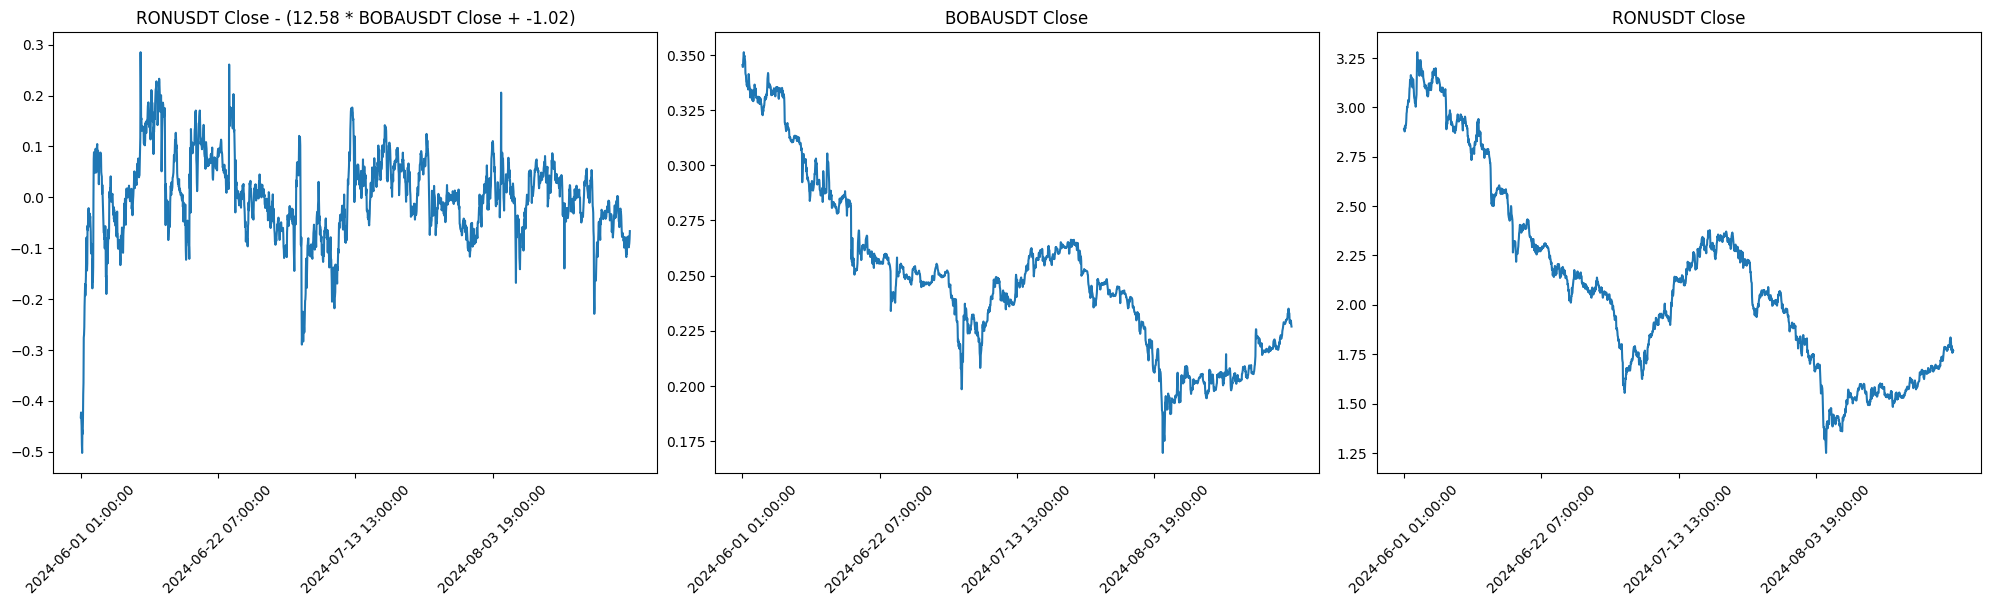

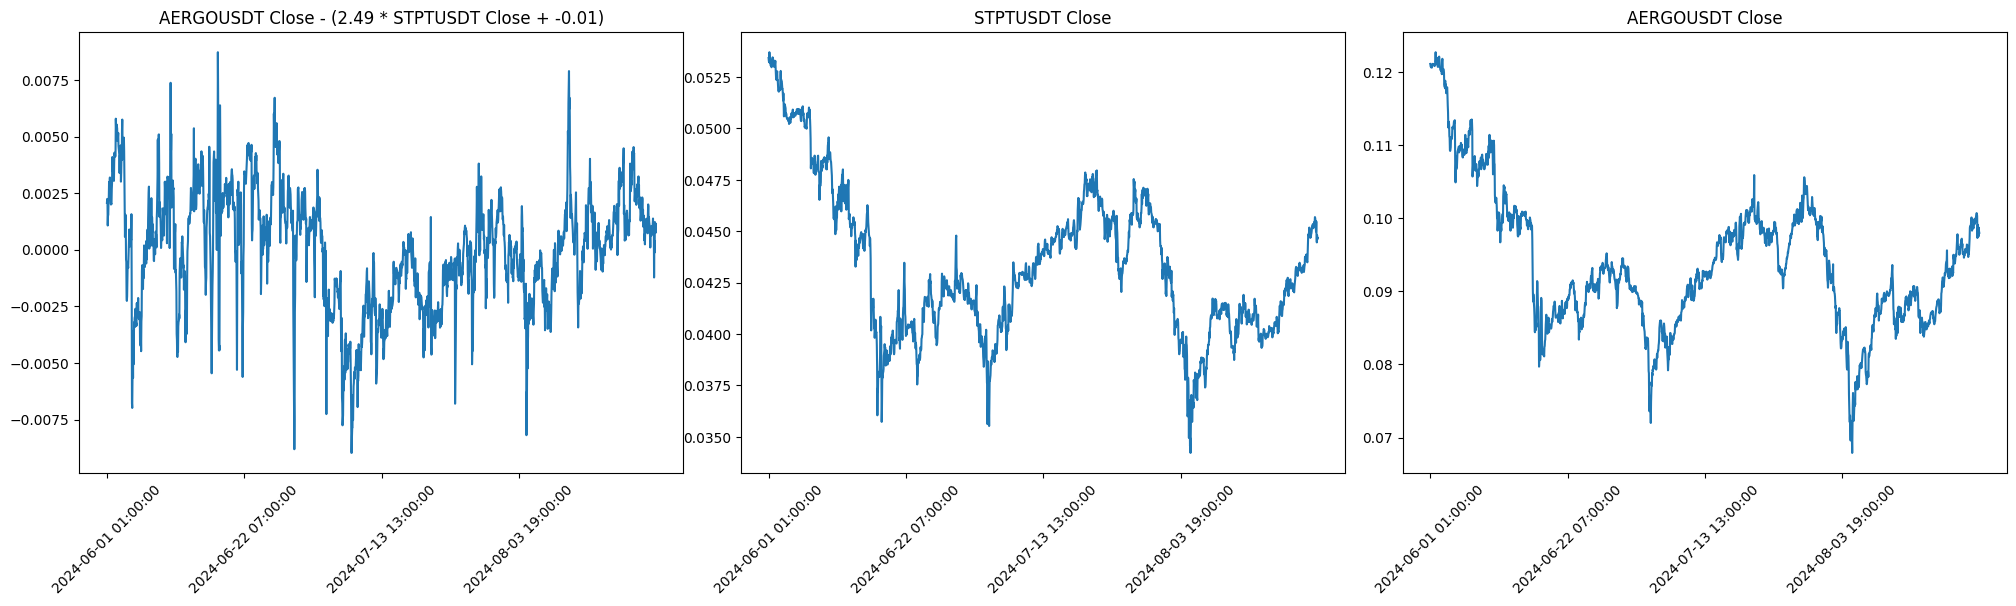

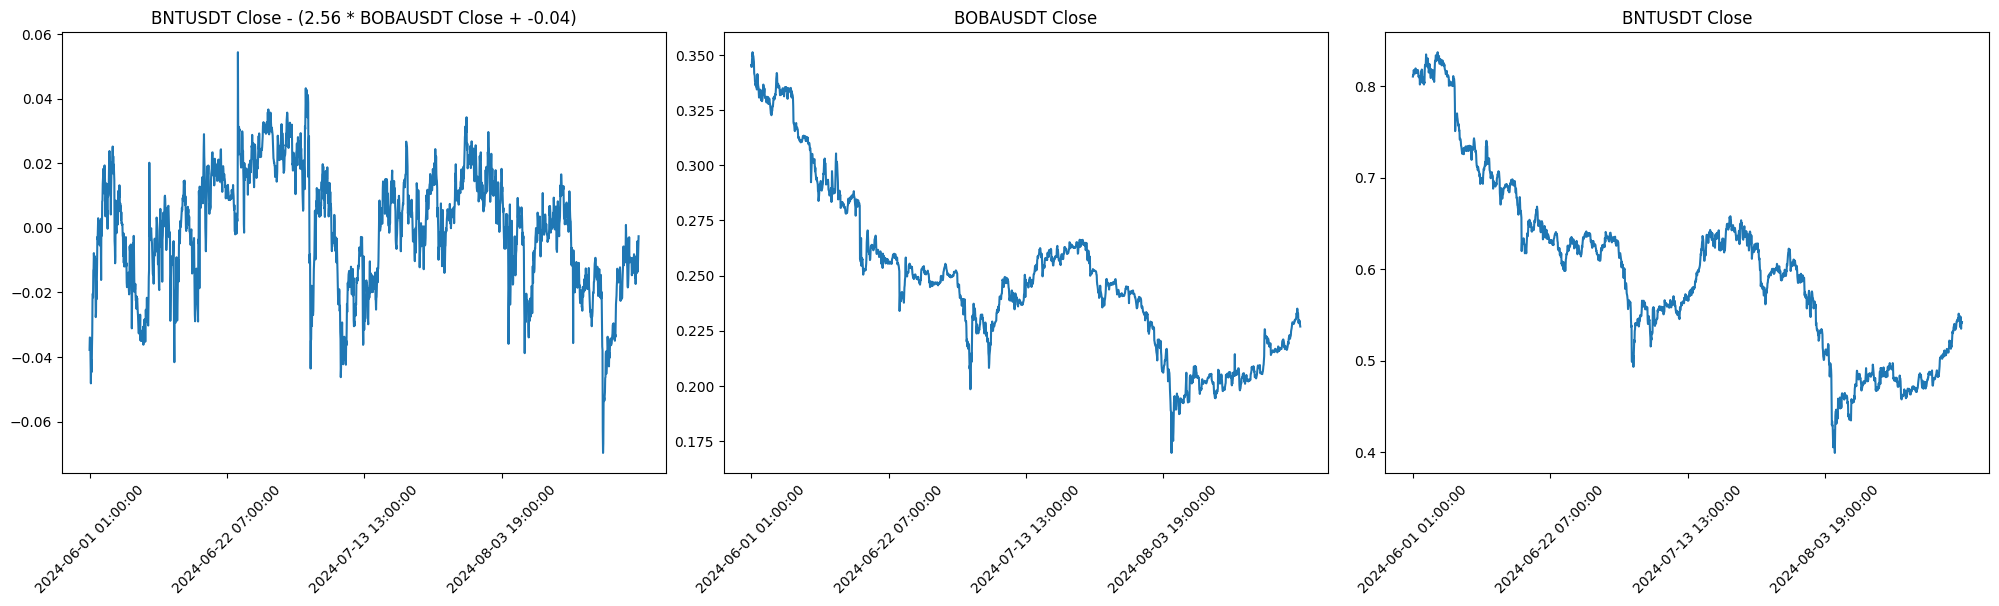

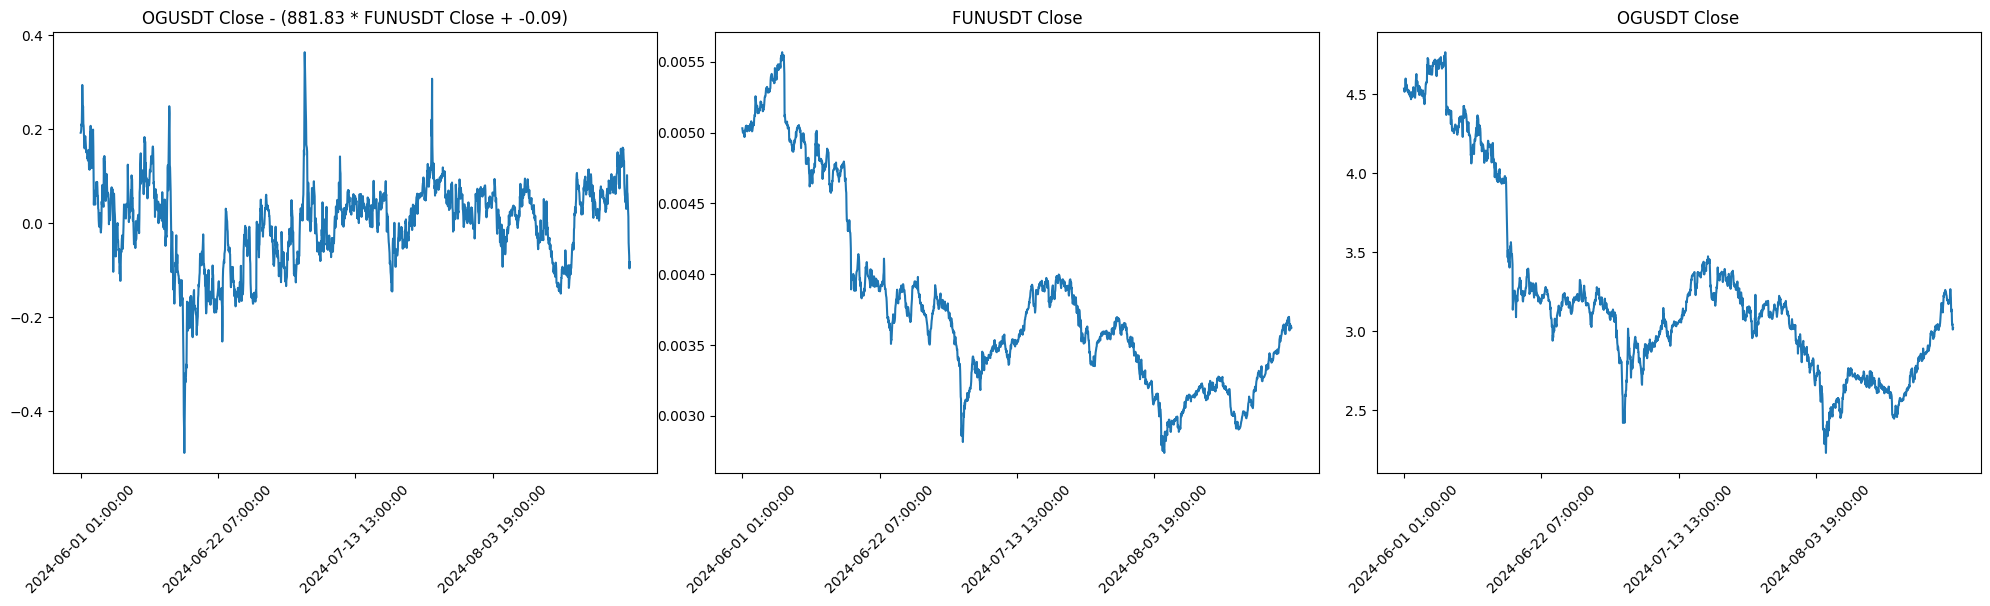

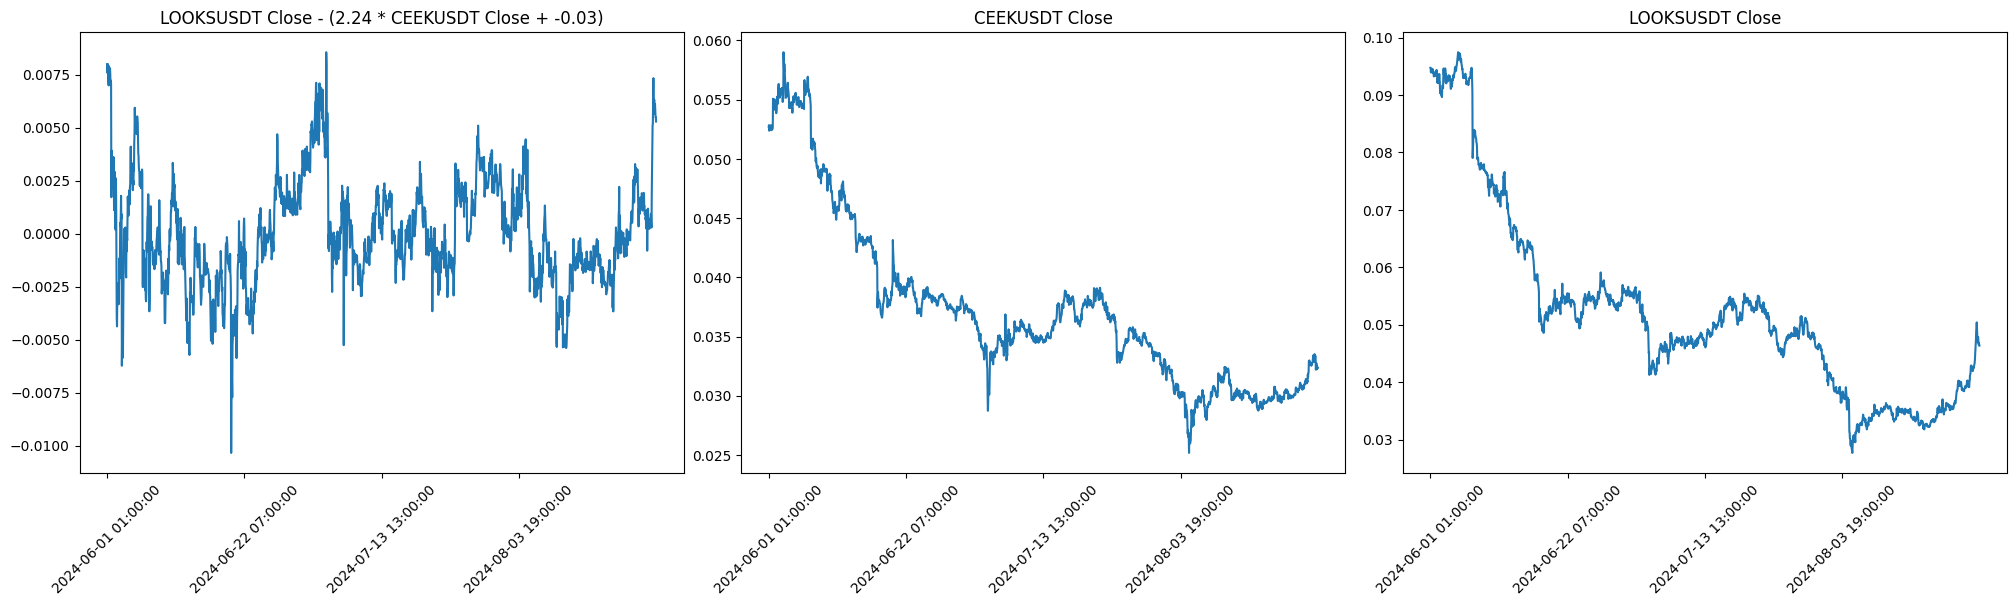

In [75]:
for i in range(5):
    stock1, stock2 = results[i][1], results[i][2]
    print(stock1, stock2)
    checkPair(stock1, stock2)